# Project: Investigating No-Show Appointments Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This report investigates a dataset of 100,000 medical appointments in Brazil. The dataset's focus is on whether patients show up for their appointments or not.

The report will explore what factors might contribute to appointment attendance.
- Primarily, do reminder text messages help? The importance here is that text messages are the one variable in our dataset a doctor's office can control.
- Does being on welfare affect attendance?
- Does the patient have a handicap?
- Which hospitals have the highest and lowest attendance rates?

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

### General Properties

In [14]:
# Read data and print the first 5 rows
df = pd.read_csv('data/noshowappointments-kagglev2-may-2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [15]:
# How many records and how many columns?
df.shape

(110527, 14)

In [16]:
# What are the column names?
df.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')

In [17]:
# What are the column data types?
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [18]:
# How many unique variables are in each column?
for col in df.columns:
    print(df[col].nunique())

62299
110527
2
103549
27
104
81
2
2
2
2
5
2
2


In [19]:
# Are there any columns with null/NA data?
# True means there are NO null values
len(df) == len(df.dropna())

True

#### The previous group of code blocks gave us the basic shape of our data. Now we can decide what to rename, clean, and recast.

We can see that there are no null values in our data so we don't have to trim anything.
However, the Handicap column should be True/False, but has 5 different values throughout the data. Making our True/False columns uniform will be necessary to properly compare statistical variables.

### Data Cleaning

In [20]:
df = df.rename(columns = {'Neighbourhood':'AppointmentLocation', 'Hipertension':'Hypertension',
                    'Handcap':'Handicap', 'SMS_received':'SMSReceived', 'No-show':'NoShow'})

#### Here we have renamed columns for misspelling and consistency.
- Neighbourhood to AppointentLocation - clarify for appointment location, **not** patient's home location.
- Hypertension - correct spelling.
- Handicap - correct spelling.
- SMSReceived - correct typecase.
- No-show to MissedAppointment - clarify that No-show: True means the appointmment was missed.

In [21]:
# The NoShow column converts all strings to True, so we need a custom conversion function for this column.
def noshow_conversion(value):
    if type(value) == str:
        if value.lower() == 'yes':
            return True
        else:
            return False
# Perform the conversion
df['NoShow'] = df['NoShow'].apply(noshow_conversion).astype(bool)
# Check that we have two unique values in our new boolean column
df['NoShow'].nunique()

2

In [22]:
# Create a list of True/False columns so we can turn them into Boolean data types
boolean_columns = ['Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handicap', 'SMSReceived']
for column in boolean_columns:
    df[column] = df[column].astype(bool)
df.dtypes

PatientId              float64
AppointmentID            int64
Gender                  object
ScheduledDay            object
AppointmentDay          object
Age                      int64
AppointmentLocation     object
Scholarship               bool
Hypertension              bool
Diabetes                  bool
Alcoholism                bool
Handicap                  bool
SMSReceived               bool
NoShow                    bool
dtype: object

#### Now we have recast each True/False column as a boolean. This gives us consistent data values to work with.

Our data is trimmed, cleaned, and uniform. Time to explore.

<a id='eda'></a>
## Exploratory Data Analysis

### Question 1: Does receiving a text message affect appointment attendance?

In [23]:
# Split data into two frames and print count of each
df_sms_received = df.query('SMSReceived == True')
df_sms_not_received = df.query('SMSReceived == False')
print("How many patients received a text message: " + str(df_sms_received.shape[0]))
print("How many patients did not receive a text message: " + str(df_sms_not_received.shape[0]))

How many patients received a text message: 35482
How many patients did not receive a text message: 75045


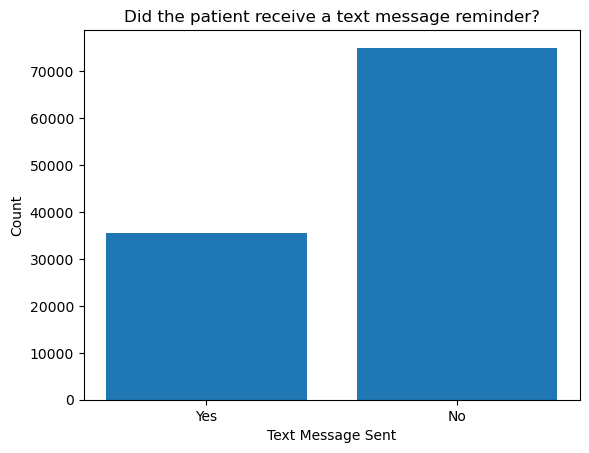

In [39]:
# Now that we have a count, we can view the data for how many appointments had text reminders and how many did not
plt.bar(['Yes', 'No'], [df_sms_received.shape[0], df_sms_not_received.shape[0]])
plt.xlabel('Text Message Sent')
plt.ylabel('Count')
plt.title('Did the patient receive a text message reminder?')
plt.show()

In [26]:
# Query how many patients who DID receive a text are Show or NoShow
sms_received_show_count = df_sms_received.query('NoShow == False').shape[0]
sms_received_noshow_count = df_sms_received.query('NoShow == True').shape[0]
print("How many patients showed up who received an SMS message? " + str(sms_received_show_count))
print("How many patients did not show up who received an SMS Message? " + str(sms_received_noshow_count))

How many patients showed up who received an SMS message? 25698
How many patients did not show up who received an SMS Message? 9784


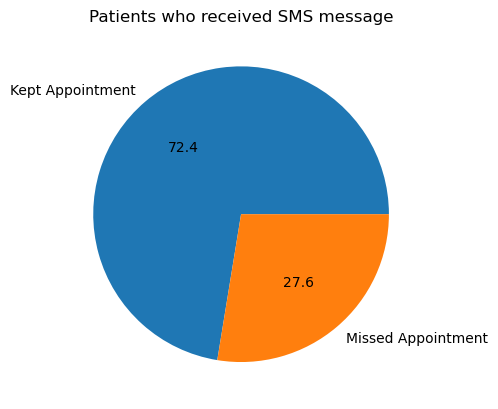

In [27]:
# Plot the data for Patients who received an SMS Message
plt.pie([sms_received_show_count, sms_received_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients who received SMS message')
plt.show()

In [28]:
# Query patients who DID NOT receive a text to find No Shows
sms_not_received_show_count = df_sms_not_received.query('NoShow == False').shape[0]
sms_not_received_noshow_count = df_sms_not_received.query('NoShow == True').shape[0]
print("How many patients showed up who received an SMS message? " + str(sms_not_received_show_count))
print("How many patients did not show up who received an SMS Message? " + str(sms_not_received_noshow_count))

How many patients showed up who received an SMS message? 62510
How many patients did not show up who received an SMS Message? 12535


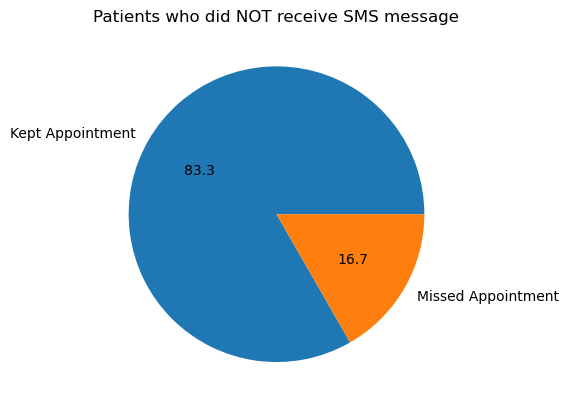

In [29]:
# Plot the data for Patients who did NOT receive an SMS message
plt.pie([sms_not_received_show_count, sms_not_received_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients who did NOT receive SMS message')
plt.show()

#### Surprisingly, patients who did NOT receive a text message were more likely to show up to appointments.
#### With this we can tentatively conclude that the SMS message does not necessarily help a patient to show up.

### Question 2: Does being on scholarship (welfare) affect a patient's appointment attendance?

In [30]:
# Split data into two frames, one for scholarship patients and the other for patients without.
df_scholarship = df.query('Scholarship == True')
df_no_scholarship = df.query('Scholarship == False')
print("Patients who have a scholarship: " + str(df_scholarship.shape[0]))
print("Patients who do NOT have a scholarship: " + str(df_no_scholarship.shape[0]))

Patients who have a scholarship: 10861
Patients who do NOT have a scholarship: 99666


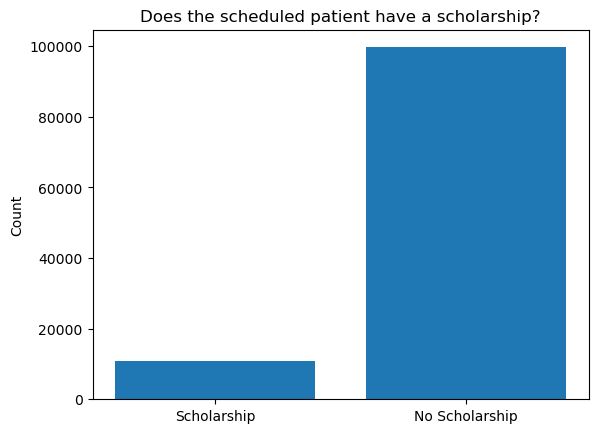

In [34]:
# Now that we have a count, we can view the data for how many patient appointments were covered by scholarship.
plt.bar(['Scholarship', 'No Scholarship'], [df_scholarship.shape[0], df_no_scholarship.shape[0]])
plt.ylabel('Count')
plt.title('Does the scheduled patient have a scholarship?')
plt.show()

We can see here that only a small section of the appointments were covered by a scholarship plan.

In [17]:
# Now query how many scholarship patients showed up or not.
scholarship_show_count = df_scholarship.query('NoShow == False').shape[0]
scholarship_noshow_count = df_scholarship.query('NoShow == True').shape[0]
print("How many patients showed up who have a scholarship? " + str(scholarship_show_count))
print("How many patients did NOT show up who have a scholarship? " + str(scholarship_noshow_count))

How many patients showed up who have a scholarship? 8283
How many patients did NOT show up who have a scholarship? 2578


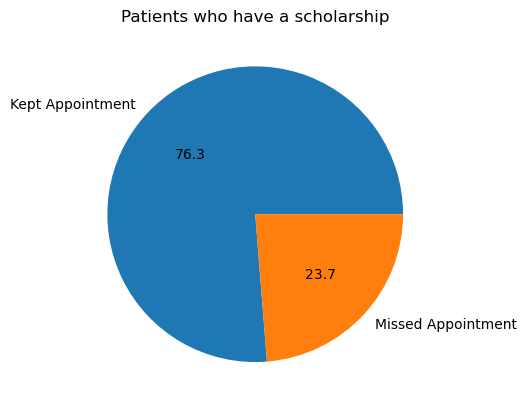

In [18]:
# Plot the data for Patients who have a scholarship
plt.pie([scholarship_show_count, scholarship_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients who have a scholarship')
plt.show()

In [19]:
# Now query how many non-scholarship patients showed up or not.
no_scholarship_show_count = df_no_scholarship.query('NoShow == False').shape[0]
no_scholarship_noshow_count = df_no_scholarship.query('NoShow == True').shape[0]
print("How many patients showed up who have a scholarship? " + str(no_scholarship_show_count))
print("How many patients did NOT show up who have a scholarship? " + str(no_scholarship_noshow_count))

How many patients showed up who have a scholarship? 79925
How many patients did NOT show up who have a scholarship? 19741


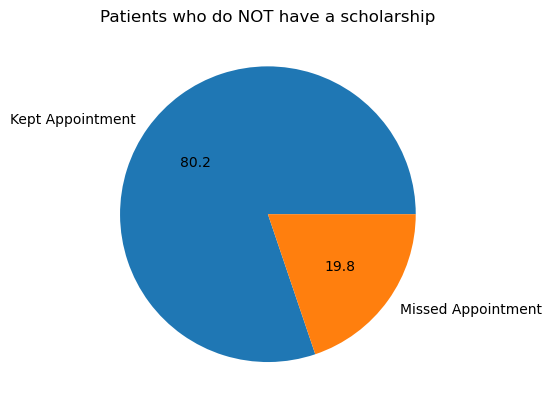

In [20]:
# Plot the data for Patients who do NOT have a scholarship
plt.pie([no_scholarship_show_count, no_scholarship_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients who do NOT have a scholarship')
plt.show()

#### The charts for scholarship patients show that people who have one will be more likely to show up for appointments.
#### However, without knowledge of other factors affecting the patient's day-to-day life it is hard to determine if the text message is a deciding factor for this group.

### Question 3: Does being handicapped affect a patient's ability to show up for appointments?

In [41]:
# Split data into two frames, one for handicap patients and the other for no handicap.
df_handicap = df.query('Handicap == True')
df_no_handicap = df.query('Handicap == False')
print("Patients who have a handicap: " + str(df_handicap.shape[0]))
print("Patients who do NOT have a handicap: " + str(df_no_handicap.shape[0]))

Patients who have a handicap: 2241
Patients who do NOT have a handicap: 108286


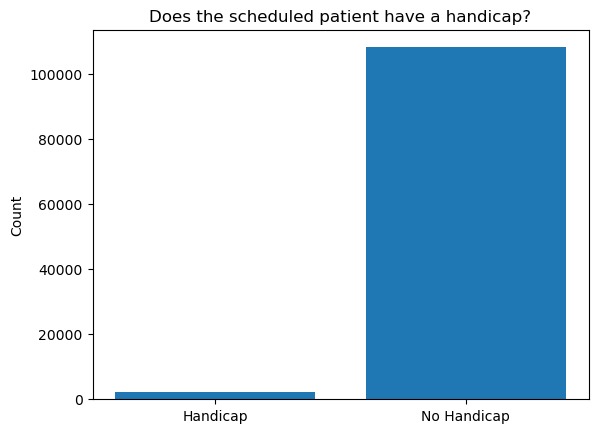

In [42]:
# Now that we have counts, let's view the data for how many patients have handicaps.
plt.bar(['Handicap', 'No Handicap'], [df_handicap.shape[0], df_no_handicap.shape[0]])
plt.ylabel('Count')
plt.title('Does the scheduled patient have a handicap?')
plt.show()

This chart illustrates what the previous show told us. That is only 2,241 patients out of over 100,000 have a disability.
While we can make assumptions from this data, now we know the pool of disabled patients for this data is limited.

In [22]:
# Query how many handicapped patients showed up to their appointments
handicap_show_count = df_handicap.query('NoShow == False').shape[0]
handicap_noshow_count = df_handicap.query('NoShow == True').shape[0]
print("Patients with a handicap who showed up to their appointments: " + str(handicap_show_count))
print("Patients with a handicap who did NOT show up to their appointments " + str(handicap_noshow_count))

Patients with a handicap who showed up to their appointments: 1834
Patients with a handicap who did NOT show up to their appointments 407


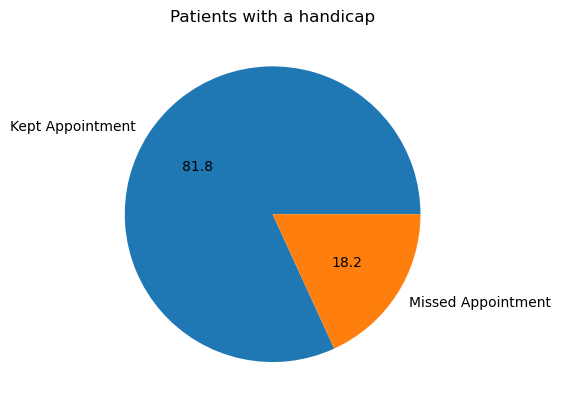

In [23]:
# Plot the data for Patients who have a handicap
plt.pie([handicap_show_count, handicap_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients with a handicap')
plt.show()

In [24]:
# Query how many patients with NO handicap showed up to appointments
nohandicap_show_count = df_no_handicap.query('NoShow == False').shape[0]
nohandicap_noshow_count = df_no_handicap.query('NoShow == True').shape[0]
print("Patients with NO handicap who showed up to their appointments: " + str(nohandicap_show_count))
print("Patients with NO handicap who did NOT show up to their appointmments: " + str(nohandicap_noshow_count))

Patients with NO handicap who showed up to their appointments: 86374
Patients with NO handicap who did NOT show up to their appointmments: 21912


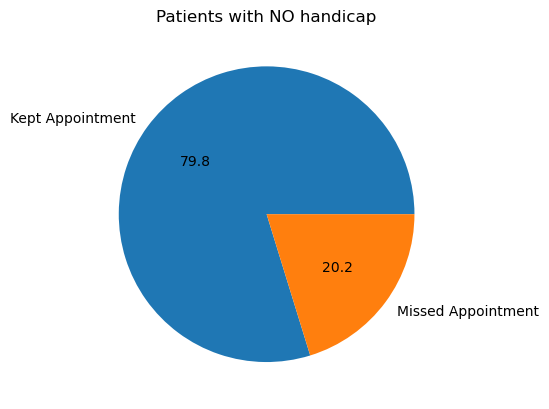

In [25]:
# Plot the data for Patients who do NOT have a handicap
plt.pie([nohandicap_show_count, nohandicap_noshow_count], labels=['Kept Appointment', 'Missed Appointment'], autopct='%.1f')
plt.title('Patients with NO handicap')
plt.show()

#### In this last research question we can see that the handicap does not seem to affect patient attendance.
#### However, the sample size for patients who do have a handicap is very small compared to the patients who do not. This could be skewing our results.

### Question 4: Which hospitals have the highest and lowest appointment attendance scores?

In [44]:
# Group Appointments by location and only pull with NoShow column
appointment_location_noshow = df.groupby('AppointmentLocation')['NoShow']

# Create a data structure to hold data until it becomes a DataFrame
location_averages = {'AppointmentLocation': [], 'NoShowPercent': []}

# Iterate the GroupBy object and calculate percentage of no-show appointments for each location
for appt_loc, noshow in appointment_location_noshow:
    location_averages['AppointmentLocation'].append(appt_loc)
    if len(noshow.value_counts()) > 1:
        percent_missed = noshow.value_counts()[1] / noshow.value_counts()[0] * 100
        location_averages['NoShowPercent'].append(percent_missed)
    else:
        location_averages['NoShowPercent'].append(None)

# Convert into a DataFrame
df_location_averages = pd.DataFrame(location_averages)

In [90]:
df['AppointmentLocation'].value_counts().sort_values()

PARQUE INDUSTRIAL                 1
ILHAS OCEÂNICAS DE TRINDADE       2
AEROPORTO                         8
ILHA DO FRADE                    10
ILHA DO BOI                      35
                               ... 
ITARARÉ                        3514
JARDIM DA PENHA                3877
RESISTÊNCIA                    4431
MARIA ORTIZ                    5805
JARDIM CAMBURI                 7717
Name: AppointmentLocation, Length: 81, dtype: int64

This data shows us that some locations have many thousands of apointments, while others have less than 100. This is something to keep in mind while gathering results based on appointment location.

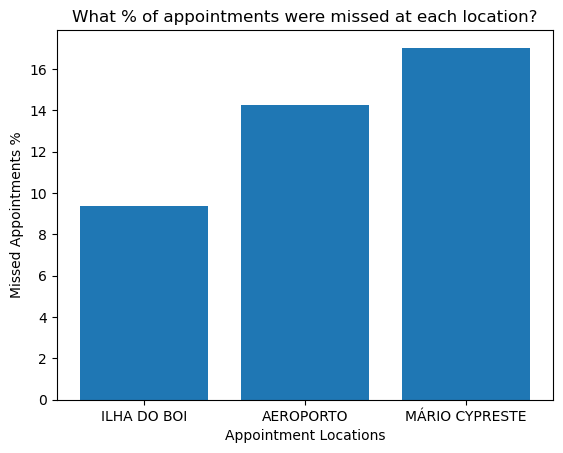

In [91]:
df_location_averages.sort_values('NoShowPercent', ascending=True, inplace=True)

# Plot a bar graph showing the lowest percent of no-shows per location using
plt.bar(df_location_averages['AppointmentLocation'].head(3), df_location_averages['NoShowPercent'].head(3))
plt.xlabel('Appointment Locations')
plt.ylabel('Missed Appointments %')
plt.title('What % of appointments were missed at each location?')
plt.show()

#### This shows us the locations with the lowest percentage of missed appointments.
Locations reporting 0 missed appointments are excluded

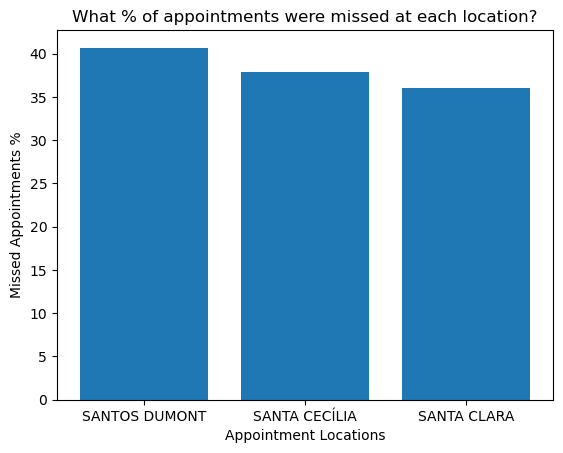

In [92]:
df_location_averages.sort_values('NoShowPercent', ascending=False, inplace=True)

# Plot a bar graph showing the lowest percent of no-shows per location using
plt.bar(df_location_averages['AppointmentLocation'].head(3), df_location_averages['NoShowPercent'].head(3))
plt.xlabel('Appointment Locations')
plt.ylabel('Missed Appointments %')
plt.title('What % of appointments were missed at each location?')
plt.show()

##

<a id='conclusions'></a>
## Conclusions

While the data is informative and can help us draw conclusions, there are missing factors that prevent us from making a true statistical conclusion. For example, we have the hospital location, but not how far the patient is traveling. This one component could change the study dramatically and allowed for alternative research questions.

With research and charting we can make some basic conclusions about patient attendance. The selected independent variable with the largest variance was whether patients received a text message or not. Surprisingly this data showed the opposite of the expected conclusion. Instead of increasing the likelihood of a patient showing up, the text messaged patients were less likely to show.

For now we can only make inferences. Perhaps with a larger dataset and more variables we would be able to draw more stastically accurate conclusions.